# Simulating the recordings of an accelerometer

## Problem

Given an accelerometer's movement, we want to calculate the readings of its directional sensors.

## Solution

If a point of mass $m$ moves following the curve $\vec r(t)$ according to one system of coordinates, the movement will _look_ as $\vec r'(t) = \vec r(t) - \vec R(t)$ from a coordinate system that is moving along the curve $\vec R(t)$ and rotating with a time-dependent orientation matrix $\omega(t)$.

It is known from Coriolis force that the equation governing the accelerations measured by the accelerometer is given by:

$$
\vec{a'} = \vec{a} - \ddot{\vec R} - \dot{\vec{\omega}}\times\vec{r'} - 2 \vec{\omega}\times \vec{v'} - \vec{\omega}\times (\vec{\omega}\times \vec{r'})
$$

where prime vectors refer to vectors measured from the non-inertial frame of reference and $\vec \omega$ is the angular speed vector, [closely related](https://en.wikipedia.org/wiki/Angular_velocity#Tensorhttps://en.wikipedia.org/wiki/Angular_velocity#Tensor) to the orientation matrix. We use the notation, very common in mechanics and kinematics, of a dot over a state to denote its derivative, i.e.:

$$
\dot f = \frac{df}{dt} \\
\ddot f = \frac{d^2 f}{dt^2}
$$

In the case of an accelerometer, the non-inertial frame travels with the object we want to study, and thus $\vec r' = \vec v' = \vec 0$.
This simplifies greatly the previous equation. All we need is:

$$
\vec a' = \vec a - \ddot{\vec R}
$$

This equation is trickier to apply than it looks. This is because we are forced to work with two different coordinate systems, and in order to operate, we need to express all the vectors present in the equation in the same one. We can use the orientation matrix for this:

$$
\begin{bmatrix}
a_x \\
a_y \\
a_z
\end{bmatrix}_{non inertial}
=
\Omega(t)
\cdot
\left(
\begin{bmatrix}
a_x \\
a_y \\
a_z
\end{bmatrix}
-
\begin{bmatrix}
\ddot R_x \\
\ddot R_y \\
\ddot R_z
\end{bmatrix}
\right)
$$

### Simplified solution

Rotations are extremelly annoying. They force us to work with a pair of coordinate systems, and thus to be explicit about coordinate transformations. Fortunately, some properties of vectors are independent of the coordinates used. And acceleration is a vector.

One of this coordinate-invariant properties is the norm. The norm represents the length of the vector or, in the case of accelerations, its magnitude. The norm is a destructive operation, in the sense that all information about directionality is neglected.

It can be proven that, if we take norms at both sides of our previous equation, the following relationship holds:

$$
\left\lVert \vec a' \right\rVert = \left\lVert  \vec a - \ddot{\vec R} \right\rVert
$$

The equation above can be used regardless of the coordinate system chosen, making it a great alternative to the full solution.

## Implementation

We want a function with the following pseudosignature:

- an input of **time** and **movement**
- an output in the form of a **time series** containing the simulated accelerations.

From the point of view of data, the **time** and the **time series** can be easily coded as a vector. But what about the **movement**? 

For the movement, we will follow the classical kinematics approach, where:

1. **Movement** is composed of displacement and rotation.
2. Displacement is described by a [trajectory](https://en.wikipedia.org/wiki/Kinematics#Kinematics_of_a_particle_trajectory_in_a_non-rotating_frame_of_reference), i.e., a function of time that returns a vector, $\vec R(t)$.
3. Rotation is described by a function of time that returns the [orientation matrix](https://en.wikipedia.org/wiki/Rotation_matrix) that transforms the non-rotating frame of reference in the rotated one, $\Omega (t)$.

For the simplified solution the orientation matrix is not required.

Some example inputs are shown below.

### Example: rectilinear movement with uniform acceleration

In this case the corresponding displacement is:

$$
\vec R(t) = \vec R_0 + \vec v_0 t + \frac{1}{2} \vec{a_0} t^2
$$

where $\vec R_0$ is the initial position, $\vec v_0$ the initial velocity and $\vec a_0$ the constant acceleration.

The movement is rectilinear, so there is no rotation:

$$
\Omega(t) = \mathbb{I}
$$

In Python terms, we can write:

```python
def R(t, R0 = np.matrix([[0],[0]]), v0 = np.matrix([[0],[0]]), a0 = np.matrix([[0],[-9.81]])):
    return R0 + v0 * t + 0.5 * a0 * t**2
```

```python
def omega(t):
    return np.identity(2)
```

### Example: uniform circular movement without frame rotation

The displacement for a circular movement is given by:

$$
\vec R(t) = R_0 \begin{bmatrix} 
                     \cos(\omega t) \\
                     \sin(\omega t)
                \end{bmatrix}
$$

where $R_0$ is the radius and $\omega$ the angular speed.

As in the example above, it there is no rotation we have $\Omega(t) = \mathbb{I}$.

In Python:

```python
def R(t, R0 = 1, w = 2*np.pi):
    return R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]])
```

```python
def omega(t):
    return np.identity(2)
```

### Example: uniform circular movement with frame rotation

If our non-inertial frame of reference rotates synchronously with the displacement, the orientation matrix becomes:

$$
\Omega(t) = \begin{bmatrix}
                \cos(\omega t) & \sin(\omega t) \\
                -\sin(\omega t) & \cos(\omega t)
            \end{bmatrix}
$$

In Python:

```python
def R(t, R0 = 1, w = 2*np.pi):
    return R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]])
```

```python
def omega(t):
    return np.matrix([[+np.cos(w*t), np.sin(w*t)], 
                      [-np.sin(w*t), np.cos(w*t)]])
```

## Code it

### Install dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.linalg import norm
import functools

### Decorators

The following decorators will be handy. We advice the reader to ignore them at this point. Their only role is to create a more handy output of functions that return matrix objects.

In [2]:
def arrayify(f):
    '''Arrayify a function from R into R^n'''
    
    def ensure_iterable(x):
        '''Coerces single number x into the one-element iterator (x, )'''
        return (x,) if not hasattr(x, '__iter__') else x
    
    @functools.wraps(f)
    def vectorized_f(ts, *args, **kwargs):
        ts = ensure_iterable(ts) # Useful for uniformity. Otherwise, calling with a double or integer would fail
        results = map(lambda t : f(t, *args, **kwargs), ts)
    
        # Create tidy output
        results_list = list(results) # List of matrices
        results_array = np.asarray(results_list).transpose()[0]
        
        return results_array
    
    return vectorized_f

# TODO: check if this can be done more elegantly with itertools, or at least merge this decorator in one
def arrayify_abs(f):
    '''Arrayify a function from R into R'''
    
    def ensure_iterable(x):
        '''Coerces single number x into the one-element iterator (x, )'''
        return (x,) if not hasattr(x, '__iter__') else x
    
    @functools.wraps(f)
    def vectorized_f(ts, *args, **kwargs):
        ts = ensure_iterable(ts) # Useful for uniformity. Otherwise, calling with a double or integer would fail
        results = map(lambda t : f(t, *args, **kwargs), ts)
    
        # Create tidy output
        results_list = list(results) # List of matrices
        results_array = np.asarray(results_list).transpose() # <-- This is the only difference with arrayify
        
        return results_array
    
    return vectorized_f 

### Calculate the acceleration "felt" by the accelerometer

The equation

$$
\vec a'_{ni}(t) = \Omega(t) \left(\vec a_{i}(t) - \ddot{\vec R}_{i}(t) \right)
$$

can be coded as



In [3]:
@arrayify
def a_ni(t, 
         a = lambda t : np.matrix([[0], [-9.8]]),
         R = lambda t : np.matrix(([0], [0])), 
         omega = lambda t : np.identity(2)):
    '''Vectorial acceleration in the non-intertial system'''

    # Auxiliary functions
    def V(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative speed'''
        return derivative(R, x0=t, dx=dx, **kwargs)

    def A(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative acceleration'''
        return derivative(V, x0=t, dx=dx, **kwargs)

    # Rotate external acceleration
    rot_a = omega(t)*a(t)

    # Calculate and rotate relative acceleration
    rot_ni = omega(t)*A(t)

    # Apply formula
    return rot_a - rot_ni

the simplified case

$$
\left\lVert \vec a'(t) \right\rVert = \left\lVert \vec a(t) - \ddot{\vec R}(t) \right\rVert
$$

can be coded as:

In [4]:
@arrayify_abs
def a_ni_abs(t, 
             a = lambda t : np.matrix([[0], [-9.8]]),
             R = lambda t : np.matrix(([0], [0]))):
    '''Absolute acceleration in the non-intertial system'''
    
    # Auxiliary functions
    def V(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative speed'''
        return derivative(R, x0=t, dx=dx, **kwargs)

    def A(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative acceleration'''
        return derivative(V, x0=t, dx=dx, **kwargs)

    return norm(a(t) - A(t))

## Play and plot

We'll need an auxiliary function to do nice plots. Certainly this can be done in a much more elegant and efficient way using vectorization, but I am feeling to lazy to try that now.

In [5]:
# The following plotting functions will be handy later
def plot_accel(ts, a_ni, a):

    accels = arrayify(a)(ts) # If we arrayify this too early, the matrix products inside a_ni will fail
    accels_ni = a_ni(ts, a, R, omega)
    ndim = len(accels_ni[:, 0]) # Number of dimensions = number of rows

    fig, axs = plt.subplots(1, ndim, sharey=True)
    fig.suptitle('Vector accelerations')

    for i in range(0, ndim):
        axs[0].plot(ts, accels[i, ])
    for i in range(0, ndim):
        axs[1].plot(ts ,accels_ni[i, ])
    for i in range(0, 2):
        axs[i].set_xlabel('time')
    
    axs[0].set_title('Intertial frame')
    axs[0].set_ylabel('Acceleration')
    axs[1].set_title('Non-intertial frame')
        
def plot_absaccel(ts, a_ni2, a):
    
    accels = arrayify(a)(ts) # If we arrayify this too early, the matrix products inside a_ni will fail
    accels_ni = a_ni_abs(ts, a, R)
    
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Total accelerations')

    axs[0].plot(ts, accels[1, ]) # TODO: actually return the norm per column
    axs[1].plot(ts ,accels_ni)
    for i in range(0, 2):
        axs[i].set_xlabel('time')
    
    axs[0].set_title('Intertial frame')
    axs[0].set_ylabel('Acceleration')
    axs[1].set_title('Non-intertial frame')

## Example: rectilinear movement with uniform acceleration (free-falling object)

In this example we simulate a free-falling object, that is, a rectilinear movement with an acceleration of $(0, -g)$. We see that the measured acceleration is $0$.

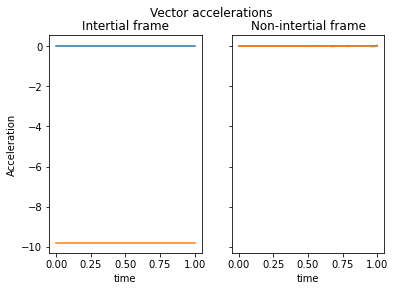

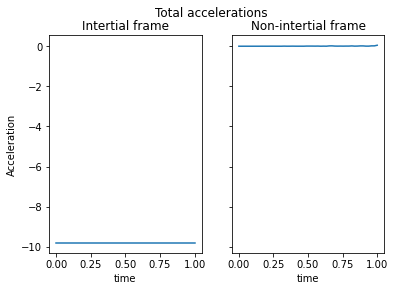

In [6]:
g = 9.81 # Acceleration of gravity (in m/s^2)

def a(t):
    '''Acceleration in the inertial system'''
    return np.matrix([[.0], 
                      [-g]])

def R(t, R0 = np.matrix([[0],[0]]), v0 = np.matrix([[0],[0]]), a0 = np.matrix([[0],[-g]])):
    '''Relative displacement'''  
    return R0 + v0 * t + 0.5 * a0 * t**2

def omega(t):
    '''Relative orientation matrix'''  
    return np.identity(2)


ts = np.linspace(0, 1)
plot_accel(ts, a_ni, a)
plot_absaccel(ts, a_ni, a)

## Example: rotation in absence of gravity

In this case, we don't expect any acceleration in the inertial system, but an outwards-pointing (positive x' axis) acceleration in the rotating one (due to the centrifugal pseudoforce).

The intensity of the centrifugal acceleration in a circular movement of radius $R$ and angular speed $\omega$ is known to be:

$$
a'(t) = \omega^2 R
$$

So, with our current parameters, we expect:

$$
a'(t) \approx \left( 40, 0 \right) \frac{m}{s^2}
$$

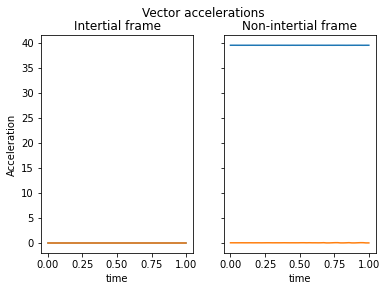

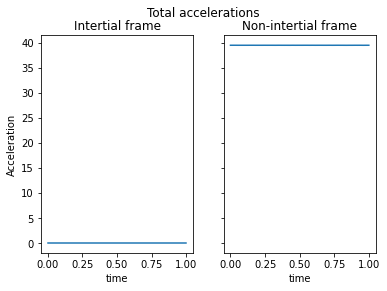

In [7]:
# Parameters
R0 = 1 # Radius of rotation
w = 2*np.pi # Angular speed

def a(t):
    '''Acceleration in the inertial system'''
    return np.matrix([[.0], 
                      [.0]])

def R(t):
    '''Relative displacement'''    
    return R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]])

def omega(t):
    '''Relative orientation matrix'''
    return np.matrix([[+np.cos(w*t), np.sin(w*t)], 
                      [-np.sin(w*t), np.cos(w*t)]])

ts = np.linspace(0, 1)
plot_accel(ts, a_ni, a)
plot_absaccel(ts, a_ni, a)

## Example: rotation and gravity

The example above can be modified slightly to introduce gravity. The results start to get interesting.

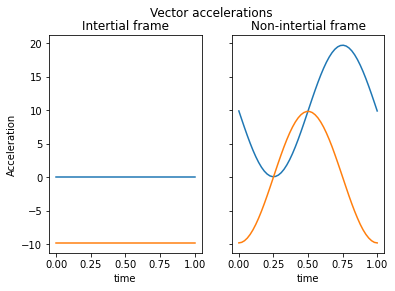

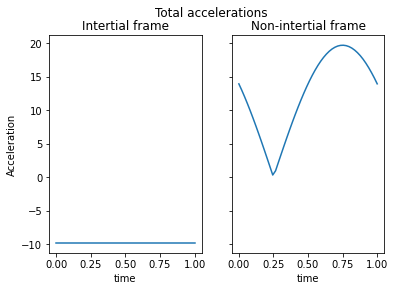

In [8]:
# Parameters
g = 9.81 # Gravitational acceleration (unsigned)
R0 = .25 # Radius of rotation
w = 2*np.pi # Angular speed

def a(t):
    '''Acceleration in the inertial system'''
    return np.matrix([[.0], 
                      [-g]])

def R(t):
    '''Relative displacement'''    
    return R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]])

def omega(t):
    '''Relative orientation matrix'''
    return np.matrix([[+np.cos(w*t), np.sin(w*t)], 
                      [-np.sin(w*t), np.cos(w*t)]])

ts = np.linspace(0, 1)
plot_accel(ts, a_ni, a)
plot_absaccel(ts, a_ni, a)

## Example: plane roller-coaster (TODO: work in progress)

If our movement traces any arbitrary curve such as:

$$
\vec r = \vec r(t)
$$

It is easy to prove that the local trihedron is given by:

$$
\begin{cases}
\begin{align}
\hat t(t) & = \frac{1}{v(t)} \dot{\vec r}(t) \\
\hat b(t) & = \hat k \\
\hat n(t) & = \hat k \times \hat t(t)
\end{align}
\end{cases}
$$

where the three vectors represent the tangent, binormal and normal directions. For convenience, we have defined:

$$
v(t) = \left | \dot{\vec r}(t) \right |
$$

and

$$
\dot{\vec r}(t) = \begin{bmatrix} v_x(t) \\ v_y(t) \end{bmatrix}
$$

The corresponding orientation matrix is thus:

$$
\Omega(t) = \frac{1}{v(t)} 
            \begin{bmatrix}
                v_x(t) & v_y(t) \\
                -v_y(t) & v_x(t)
            \end{bmatrix}
$$

This allows us to write a more automatic version of the previous functions, where the orientation matrix is calculated automatically.

In [9]:
def a_ni_auto(t, 
              a = lambda t : np.matrix([[0], [-9.8]]),
              R = lambda t : np.matrix(([0], [0]))):
    '''Vectorial acceleration in the non-intertial system'''
    
    # Auxiliary functions
    def V(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative speed'''
        return derivative(R, x0=t, dx=dx, **kwargs)
    
    def vx(t):
        ''' Component x of velocity'''
        return float(V(t)[0]) 
    
    def vy(t):
        ''' Component y of velocity'''
        return float(V(t)[1]) 
    
    def omega(t):
        '''Relative orientation matrix'''
        magnitude = np.sqrt(vx(t)**2 + vy(t)**2)
        matrix = np.matrix([[vx(t), vy(t)], 
                            [-vy(t), vx(t)]])
        
        return 1 / magnitude * matrix 
    
    return a_ni(t, a, R, omega)

Let's play with it, simulating, for instance, a sinusoidal roller-coaster:

$$
\vec r(t) = \begin{bmatrix} t \\ \sin(t) \end{bmatrix}
$$

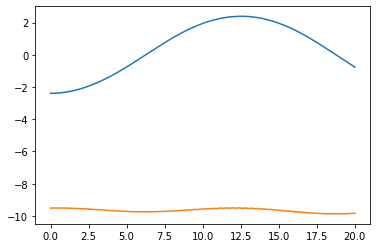

In [10]:
# Parameters
g = 9.81 # Gravitational acceleration (unsigned)
w = 2*np.pi / 25 # Angular speed

def a(t):
    '''Acceleration in the inertial system'''
    return np.matrix([[.0], 
                      [-g]]) 

def R(t):
    '''Relative displacement'''    
    return np.matrix([[t],
                      [np.sin(w*t)]])

# Times to plot
ts = np.linspace(0, 20, 500)
plt.plot(ts, a_ni_auto(ts, a, R)[0, ])
plt.plot(ts, a_ni_auto(ts, a, R)[1, ])

Or a spiral rollercoaster:

$$
\vec r(t) = \begin{bmatrix} t \cos(\omega t) \\ t \sin(\omega t) \end{bmatrix}
$$

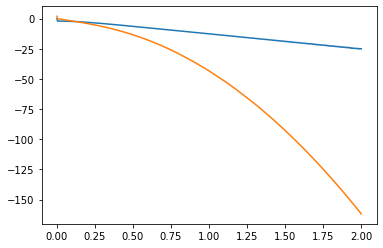

In [15]:
# Parameters
g = 0*9.81 # Gravitational acceleration (unsigned)
w = 2*np.pi # Angular speed

def a(t):
    '''Acceleration in the inertial system'''
    return np.matrix([[.0], 
                      [-g]]) 

def R(t):
    '''Relative displacement'''    
    return np.matrix([[t**2 * np.cos(w*t)],
                      [t**2 * np.sin(w*t)]])

# Times to plot
ts = np.linspace(0, 2, 500)
plt.plot(ts, a_ni_auto(ts, a, R)[0, ])
plt.plot(ts, a_ni_auto(ts, a, R)[1, ])

## Testing

With the comparing function below we can check that our norm approach is equivalent to the vectorial one

1.7763568394002505e-15

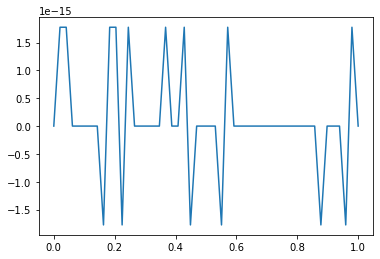

In [11]:
# TODO: use vectorized functions to write this test more elegantly
def comparer(ts, plot=True):
    ''' Compare the absolute accelerations calculated from vector or from norm approaches'''
    # Containers for the accelerations
    
    ## Inertial frame
    asx = np.zeros(len(ts)) # x
    asy = np.zeros(len(ts)) # y
    asa = np.zeros(len(ts)) # Absolute
    
    ## Non-inertial frame
    asnix = np.zeros(len(ts)) # x
    asniy = np.zeros(len(ts)) # y
    asnia1 = np.zeros(len(ts)) # Absolute (calculated from vectorial)
    asnia2 = np.zeros(len(ts)) # Absolute (calculated from norm)
    
    # Loop and unpack information
    for i in range(len(ts)):
        accels = a(ts[i])
        asx[i] = accels[0]
        asy[i] = accels[1]
        asa[i] = np.sqrt(accels[0]**2 + accels[1]**2)
    
        accels_ni = a_ni(ts[i], a, R, omega) # a, R and omega are taken from the environment. Probably not a good practice
        asnix[i] = accels_ni[0]
        asniy[i] = accels_ni[1]
        asnia1[i] = np.sqrt(accels_ni[0]**2 + accels_ni[1]**2)
        asnia2[i] = a_ni_abs(ts[i], a, R)
    
    if plot:
        plt.plot(ts, asnia1 - asnia2)
    
    ## We expect the absolute error to be negligible
    absErr = np.max(np.abs(asnia1 - asnia2))
    return absErr 
    
ts = np.linspace(0, 1)
comparer(ts)

## To be continued

Check TODOs.